In [92]:
import __init__ # set up all the correct referenses
import os
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt



import seaborn as sns

from sklearn.neighbors import NearestNeighbors, KDTree, kneighbors_graph
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PowerTransformer
import sklearn.preprocessing as preprocessing
from sklearn.manifold import TSNE

from sknetwork.clustering import Louvain, get_modularity

import datetime

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from phenograph.cluster import cluster as cluster2

#import gower

import __init__
from utils.propensity import Propensity
from utils.lifelines_preprocess import surv_functions
from utils.sequence_analysis import trajectory_seq_analysis

cmap = plt.get_cmap("tab20")

run_all = True

print(pd.__version__)
print(np.__version__)

2.2.3
1.26.4


In [93]:


subproject_name = "trajectories"

wd = "../../../"
project_path = os.path.realpath(wd)
print(project_path)

raw_data_dir = project_path+"/raw_data/"
print(raw_data_dir)


data_dir = project_path+f"/{subproject_name}"+"/data/"
print(data_dir)

results_dir = project_path+f"/{subproject_name}"+"/output/"
print(results_dir)


/exports/reum/nsteinz/Project_trajectories
/exports/reum/nsteinz/Project_trajectories/raw_data/
/exports/reum/nsteinz/Project_trajectories/trajectories/data/
/exports/reum/nsteinz/Project_trajectories/trajectories/output/


In [94]:
features_nl = [#'Basophils',
    'Total Tender', 
            'Total Swollen',
           
            #'CRP Value (mg/L)', 
            #'DAS-28 CRP', 
            #'DAS28',
           'ESR Value',
    'WBC',        
    #'Eosinophils', 
            'hb_corrected', 
            #'Lymphocytes', 
            #'Monocytes',
       #'Neutrophils', 
            'PLT', 
            #'Rheum Factor positive', 
            
            
           
           ]

features = [#'Basophils',
            'TJC_28', 
            'SJC_28',
           
            #'CRP Value (mg/L)', 
            #'DAS-28 CRP', 
            #'DAS28',
           'ESR',
    'leukocytes',        
    #'Eosinophils', 
            'hemoglobin', 
            #'Lymphocytes', 
            #'Monocytes',
       #'Neutrophils', 
            'thrombocytes', 
            #'Rheum Factor positive', 
            
            
           ]

FA = 'Folic Acid'
predni = ['Methylprednisolone','Methylprednisolone Acetate', 'Prednisolone']
dmards = ['Adalimumab', 'Certolizumab', 'Dexamethasone',
       'Etanercept', 'Golimumab', 'Hydroxychloroquine',
       'Leflunomide', 'Methotrexate']+ predni + ['Sulfasalazine',
       'Tocilizumab', 'Triamcinolone (Kenalog)']
dmards = ['Adalimumab', 'Certolizumab', 'Dexamethasone',
       'Etanercept', 'Golimumab', 'Hydroxychloroquine',
       'Leflunomide', 'Methotrexate']+ ['Sulfasalazine',
       'Tocilizumab', 'Triamcinolone (Kenalog)']
dmard_types = {
    "TNF_b_dmards" : ['ETANERCEPT', 'GOLIMUMAB','INFLIXIMAB','CERTOLIZUMAB_PEGOL', 'ADALIMUMAB'],
    "IL6_b_dmards" : ['CERTOLIZUMAB_PEGOL', 'TOCILIZUMAB'],
    "IL1_b_dmards" : ['ANAKINRA'],
    "tcell_b_dmards" : ['ABATACEPT'],
    "cs_dmards" : ["METHOTREXATE",'HYDROXYCHLOROQUINE','LEFLUNOMIDE', 'SULFASALAZINE'],
    "jak_dmard" : ['TOFACITINIB', 'BARICITINIB'],
    "XO_damrd" : ['AZATHIOPRINE'],
    "OP_dmard" : ["CYCLOPHOSPHAMIDE"],
    "TC_dmard" : ["CICLOSPORINE"],
    "gld_dmard": ["SODIUM_AUROTHIOMALATE"]
    #"predni":  ['PREDNISOLONE',"METHYLPREDNISOLONE"],
}
set(dmards)- set([j for x in dmard_types for j in dmard_types[x]])

feature_remap = dict(zip(features_nl,features))

In [95]:
x = pd.read_csv(raw_data_dir +"RA-MAP_data_clinical.csv")
z = x.loc[:,x.columns.str.contains("HB ")]
z.dropna().describe()
(list(x.columns))
x.loc[:,x.columns.str.contains("Study")]
pats = x[x["\\RAMAP\\RAMAP\\Study\\"]	== "TACERA"]["Subject ID"]


In [96]:
data_dir +"TACERA_data_.csv"

'/exports/reum/nsteinz/Project_trajectories/trajectories/data/TACERA_data_.csv'

In [97]:
data_use = pd.read_csv(data_dir +f"TACERA_data_2024-03-12.csv")
#data_use = pd.read_csv(data_dir +f"TACERA_data_.csv")
#PATNRS = pd.read_csv(data_dir +"TACERA_data_old.csv").query("Study == 'TACERA'")


data_use = data_use.reset_index(drop=True)
#data_use = PATNRS
data_use.columns
data_use['Subject ID'].unique().__len__()




268

In [98]:
new_tacera = pd.read_excel("/exports/reum/nsteinz/Project_trajectories/raw_data/TACERA_raw/Protogen_RA_MAP_16_05_21.xlsx", sheet_name="Sample annotation")
raw_tacera = pd.read_csv(raw_data_dir +"RA-MAP_data_clinical.csv")


In [99]:
#serops = data_use[["Subject ID", "ACPA positive", "Rheum Factor positive"]].replace("Yes",1).replace("No",0).groupby("Subject ID").max().fillna(0)
#serops = serops.reset_index().rename(columns = {"ACPA positive": "acpa", "Rheum Factor positive":"RF"})
#data_use = data_use.merge(serops, on="Subject ID" ,how="left")
data_use
data_cluster = data_use

In [100]:
data_use = data_use.rename(columns={"ACPA positive":"acpa", "Rheum Factor positive":"RF"})

In [101]:
data_use["seropos"] = False
data_use.loc[data_use.query("acpa == True or RF == True").index,"seropos"] = True


In [102]:
data_use.loc[data_use.query("HB < 30").index,"HB"] = data_use.query("HB < 30").HB*10


In [103]:
data_use["Hemoglobulin"] = (data_use.HB * 0.06206)


In [104]:
data_use.loc[data_use[["Hemoglobulin","Sex"]].query("Sex=='Female'").index ,"hb_corrected"]= (data_use[["Hemoglobulin","Sex"]].query("Sex=='Female'").Hemoglobulin +0.5) 
data_use.loc[data_use[["Hemoglobulin","Sex"]].query("Sex=='Male'").index ,"hb_corrected"]= (data_use[["Hemoglobulin","Sex"]].query("Sex=='Male'").Hemoglobulin -0.5)

In [105]:
data_cluster = data_use.query("WBC > 0").reset_index(drop=True)

data_cluster.columns
data_cluster = data_cluster.rename(columns=feature_remap)

In [106]:
data_cluster["das_28_c"]=(0.56*np.sqrt(data_cluster.TJC_28) + 0.28* np.sqrt( data_cluster.SJC_28) + 0.70*np.log(data_cluster.ESR))*1.08 + 0.16
#(0.56*np.sqrt(data_cluster.TJC_28) + 0.28* np.sqrt( data_cluster.SJC_28) + 0.70 * np.log(data_cluster.ESR))*1.08 + 0.16

In [107]:
data_cluster.Sex = data_cluster.Sex.astype("category") 


In [108]:
pats = data_cluster.groupby("Subject ID").count().query("Study >=2").index


In [109]:
visit_counts = data_cluster.groupby("Subject ID").count()[["months"]].rename(columns={"months":"visit_count"})


In [110]:
data_cluster = data_cluster.merge(visit_counts, on="Subject ID", )

In [111]:
data_cluster = data_cluster.query("`Subject ID` in @pats").reset_index(drop=True)
data_cluster.columns

Index(['Subject ID', 'months', 'Study', 'Age', 'Race', 'Sex', 'Weight',
       'Date of Assessment', 'Date of symptom onset', 'Final Score',
       'Unnamed: 10', 'acpa', 'RF', 'ACPA positive SCR',
       'Rheum Factor positive SCR', 'Basophils', 'CRP Value (mg/L)',
       'DAS-28 CRP', 'DAS28', 'ESR', 'Eosinophils', 'GL', 'HB', 'Lymphocytes',
       'Monocytes', 'Neutrophils', 'thrombocytes', 'SJC_28', 'TJC_28',
       'leukocytes', 'Adalimumab', 'Certolizumab', 'Dexamethasone',
       'Etanercept', 'Folic Acid', 'Golimumab', 'Hydroxychloroquine',
       'Leflunomide', 'Methotrexate', 'Methylprednisolone',
       'Methylprednisolone Acetate', 'Prednisolone', 'Sulfasalazine',
       'Tocilizumab', 'Triamcinolone (Kenalog)', 'days', 'seropos',
       'Hemoglobulin', 'hemoglobin', 'das_28_c', 'visit_count'],
      dtype='object')

In [112]:
print(data_cluster.groupby("Subject ID").head(1).seropos.value_counts().iloc[0],data_cluster.groupby("Subject ID").head(1).seropos.value_counts(normalize=True).iloc[0].round(3))

243 1.0


In [113]:
print(data_cluster.groupby("Subject ID").head(1).acpa.value_counts().iloc[0],data_cluster.groupby("Subject ID").head(1).acpa.value_counts(normalize=True).iloc[0].round(3))

207 0.855


In [114]:
print(data_cluster.groupby("Subject ID").head(1).RF.value_counts().iloc[0],data_cluster.groupby("Subject ID").head(1).RF.value_counts(normalize=True).iloc[0].round(3))

223 0.918


In [115]:
cat_columns = data_cluster.select_dtypes(['category']).columns

In [116]:

# adds a row that shows if a patient uses multiple dmards
data_cluster["predni"] = (data_cluster[predni].sum(axis=1) >= 1)*1
data_cluster["m_dmards"] = data_cluster[dmards].sum(axis=1) > 1
data_cluster["dmard_usage"] = data_cluster[dmards].sum(axis=1) >= 1
data_cluster["Sex"] = data_cluster.Sex.astype("category")
data_cluster[cat_columns] = data_cluster[cat_columns].apply(lambda x: np.abs(1-x.cat.codes))
data_cluster.columns

Index(['Subject ID', 'months', 'Study', 'Age', 'Race', 'Sex', 'Weight',
       'Date of Assessment', 'Date of symptom onset', 'Final Score',
       'Unnamed: 10', 'acpa', 'RF', 'ACPA positive SCR',
       'Rheum Factor positive SCR', 'Basophils', 'CRP Value (mg/L)',
       'DAS-28 CRP', 'DAS28', 'ESR', 'Eosinophils', 'GL', 'HB', 'Lymphocytes',
       'Monocytes', 'Neutrophils', 'thrombocytes', 'SJC_28', 'TJC_28',
       'leukocytes', 'Adalimumab', 'Certolizumab', 'Dexamethasone',
       'Etanercept', 'Folic Acid', 'Golimumab', 'Hydroxychloroquine',
       'Leflunomide', 'Methotrexate', 'Methylprednisolone',
       'Methylprednisolone Acetate', 'Prednisolone', 'Sulfasalazine',
       'Tocilizumab', 'Triamcinolone (Kenalog)', 'days', 'seropos',
       'Hemoglobulin', 'hemoglobin', 'das_28_c', 'visit_count', 'predni',
       'm_dmards', 'dmard_usage'],
      dtype='object')

In [117]:
data_cluster["Sex"] = data_cluster["Sex"].replace("Female", 1).replace("Male", 0).astype(int)

In [118]:
data_cluster.groupby("Subject ID").count().months.describe()

count    243.000000
mean       3.086420
std        0.860485
min        2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: months, dtype: float64

In [119]:
data_cluster["remision"] = (data_cluster.DAS28 <2.6).astype(int)


In [120]:

def print_latex_table_EHR(dataset, 
                          groupby="Subject ID",
                          query = "label==@j" , 
                          type_ = "trajectory", 
                          volgorde= None,
                         features_median = [],
                          features_mean= [],
                          features_add = ["dmard_usage","RF", "acpa", "Sex"]
                         ):
    if query == None:
        query = 'ilevel_0 in ilevel_0'
    print("Features", end ="")
    for i in volgorde:
        print(" & ", end="")
        print(type_,i, end="")
    print("\\\\\\hline")

    for j in volgorde:

        z = (dataset.query(query)
                        .groupby(groupby)
                        )
        print(f"n= &{z.head(1).count().iloc[1]}&")
        visits = z.count().iloc[:,1]
        print(f"nr of visits (IQR)& {visits.median()} ({float(round(visits.quantile(q=0.25),1))} - {float(round(visits.quantile(q=0.75),1))})&", end="")
    print("\\\\")
    for i in features_median:
        print(i,"$\space$ (IQR) $\space\dagger$ ", end= "")
        for j in volgorde:
            print(" & ", end="")
            z = (dataset.query(query)
                        .groupby(groupby)
                        .head(1)[i])
            print(f"{float(round(z.median(),1))} ({float(round(z.quantile(q=0.25),1))} - {float(round(z.quantile(q=0.75),1))})", end="")
        print("\\\\")
    for i in features_mean:
        print(i,"$\space$ (±IQR) $\space\dagger$ ", end= "")
        for j in volgorde:
            print(" & ", end="")
            z = (dataset.query(query)
                        .groupby(groupby)
                        .head(1)[i])
            print(f"{float(round(z.mean(),2))} ({float(round(z.std(),2))})", end="")
        print("\\\\")
    for i in features_add:
        print(i,"(\\%)", end= "")
        for j in volgorde:
            print(" & ", end="")
            z = (dataset.query(query)
                        .groupby(groupby)
                        .head(1)[i])
            print(f"{int(round(z.sum(),0))} ({round(z.mean()*100, 1)})", end="")

        print("\\\\")



In [121]:

data = data_cluster
print_latex_table_EHR(data, query=None,type_="", volgorde =[5], features_median= features, features_mean=  ["das_28_c","Age", "seropos", "remision"] )

Features &  5\\\hline
n= &243&
nr of visits (IQR)& 3.0 (2.0 - 4.0)&\\
TJC_28 $\space$ (IQR) $\space\dagger$  & 9.0 (4.0 - 14.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & 6.0 (3.0 - 9.5)\\
ESR $\space$ (IQR) $\space\dagger$  & 27.0 (12.0 - 42.5)\\
leukocytes $\space$ (IQR) $\space\dagger$  & 7.8 (6.6 - 9.2)\\
hemoglobin $\space$ (IQR) $\space\dagger$  & 8.5 (7.9 - 8.9)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & 293.0 (255.0 - 365.0)\\
das_28_c $\space$ (±IQR) $\space\dagger$  & 4.95 (1.29)\\
Age $\space$ (±IQR) $\space\dagger$  & 52.95 (14.92)\\
seropos $\space$ (±IQR) $\space\dagger$  & 1.0 (0.0)\\
remision $\space$ (±IQR) $\space\dagger$  & 0.03 (0.17)\\
dmard_usage (\%) & 223 (91.8)\\
RF (\%) & 223 (91.8)\\
acpa (\%) & 207 (85.5)\\
Sex (\%) & 177 (72.8)\\


In [122]:
data_cluster.columns

Index(['Subject ID', 'months', 'Study', 'Age', 'Race', 'Sex', 'Weight',
       'Date of Assessment', 'Date of symptom onset', 'Final Score',
       'Unnamed: 10', 'acpa', 'RF', 'ACPA positive SCR',
       'Rheum Factor positive SCR', 'Basophils', 'CRP Value (mg/L)',
       'DAS-28 CRP', 'DAS28', 'ESR', 'Eosinophils', 'GL', 'HB', 'Lymphocytes',
       'Monocytes', 'Neutrophils', 'thrombocytes', 'SJC_28', 'TJC_28',
       'leukocytes', 'Adalimumab', 'Certolizumab', 'Dexamethasone',
       'Etanercept', 'Folic Acid', 'Golimumab', 'Hydroxychloroquine',
       'Leflunomide', 'Methotrexate', 'Methylprednisolone',
       'Methylprednisolone Acetate', 'Prednisolone', 'Sulfasalazine',
       'Tocilizumab', 'Triamcinolone (Kenalog)', 'days', 'seropos',
       'Hemoglobulin', 'hemoglobin', 'das_28_c', 'visit_count', 'predni',
       'm_dmards', 'dmard_usage', 'remision'],
      dtype='object')

In [123]:

data = data_cluster.sort_values("days").groupby("Subject ID").head(1).reset_index()
print_latex_table_EHR(data, query=None,type_="", volgorde =[5], features_median= features + ['CRP Value (mg/L)',"Hemoglobulin","das_28_c"], features_mean=  ["Age", "seropos", "remision"] )

Features &  5\\\hline
n= &243&
nr of visits (IQR)& 1.0 (1.0 - 1.0)&\\
TJC_28 $\space$ (IQR) $\space\dagger$  & 9.0 (4.0 - 14.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & 6.0 (3.0 - 9.5)\\
ESR $\space$ (IQR) $\space\dagger$  & 27.0 (12.0 - 42.5)\\
leukocytes $\space$ (IQR) $\space\dagger$  & 7.8 (6.6 - 9.2)\\
hemoglobin $\space$ (IQR) $\space\dagger$  & 8.5 (7.9 - 8.9)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & 293.0 (255.0 - 365.0)\\
CRP Value (mg/L) $\space$ (IQR) $\space\dagger$  & 8.1 (5.0 - 20.0)\\
Hemoglobulin $\space$ (IQR) $\space\dagger$  & 8.2 (7.5 - 8.8)\\
das_28_c $\space$ (IQR) $\space\dagger$  & 5.0 (4.1 - 5.8)\\
Age $\space$ (±IQR) $\space\dagger$  & 52.95 (14.92)\\
seropos $\space$ (±IQR) $\space\dagger$  & 1.0 (0.0)\\
remision $\space$ (±IQR) $\space\dagger$  & 0.03 (0.17)\\
dmard_usage (\%) & 223 (91.8)\\
RF (\%) & 223 (91.8)\\
acpa (\%) & 207 (85.5)\\
Sex (\%) & 177 (72.8)\\


In [124]:

data = data_cluster.sort_values("days").groupby("Subject ID").tail(1).reset_index()
print_latex_table_EHR(data, query=None,type_="", volgorde =[5], features_median= features +['CRP Value (mg/L)',"Hemoglobulin","das_28_c"], features_mean=  ["das_28_c","Age", "seropos","remision"] )

Features &  5\\\hline
n= &243&
nr of visits (IQR)& 1.0 (1.0 - 1.0)&\\
TJC_28 $\space$ (IQR) $\space\dagger$  & 2.0 (0.0 - 5.0)\\
SJC_28 $\space$ (IQR) $\space\dagger$  & 1.0 (0.0 - 3.0)\\
ESR $\space$ (IQR) $\space\dagger$  & 12.0 (6.0 - 24.0)\\
leukocytes $\space$ (IQR) $\space\dagger$  & 6.3 (5.1 - 7.8)\\
hemoglobin $\space$ (IQR) $\space\dagger$  & 8.5 (8.0 - 8.9)\\
thrombocytes $\space$ (IQR) $\space\dagger$  & 266.5 (225.5 - 312.0)\\
CRP Value (mg/L) $\space$ (IQR) $\space\dagger$  & 5.0 (2.0 - 6.0)\\
Hemoglobulin $\space$ (IQR) $\space\dagger$  & 8.2 (7.6 - 8.8)\\
das_28_c $\space$ (IQR) $\space\dagger$  & 3.0 (2.0 - 3.9)\\
das_28_c $\space$ (±IQR) $\space\dagger$  & 3.05 (1.35)\\
Age $\space$ (±IQR) $\space\dagger$  & 52.95 (14.92)\\
seropos $\space$ (±IQR) $\space\dagger$  & 1.0 (0.0)\\
remision $\space$ (±IQR) $\space\dagger$  & 0.41 (0.49)\\
dmard_usage (\%) & 229 (94.2)\\
RF (\%) & 223 (91.8)\\
acpa (\%) & 207 (85.5)\\
Sex (\%) & 177 (72.8)\\


In [125]:
z = data_cluster.sort_values("days").groupby("Subject ID").head(1).ESR
print(f"{round(z.median(),0)} {round(z.quantile(q=0.25),0), round(z.quantile(q=0.75),0)}", end="")

27.0 (12.0, 42.0)

<Axes: >

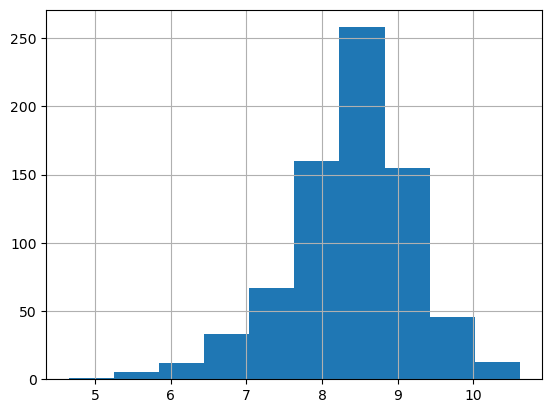

In [126]:
data_cluster.hemoglobin.hist()

In [127]:
data_cluster[features]

,TJC_28,SJC_28,ESR,leukocytes,hemoglobin,thrombocytes
0,20,19,60.0,6.0,7.45072,349.0
1,0,2,10.0,6.8,7.38866,312.0
2,15,7,9.0,9.4,9.18840,277.0
3,5,0,7.0,8.4,8.50574,272.0
4,13,1,12.0,6.4,8.44368,271.0
...,...,...,...,...,...,...
745,0,2,8.0,6.1,8.37458,341.0
746,13,10,29.0,7.8,8.38162,304.0
747,19,3,18.0,6.6,8.62986,290.0
748,23,6,31.0,4.2,8.38162,253.0


In [128]:
# make adjecentie matrix
scaler =MinMaxScaler( feature_range=(0, 1))
scaler = scaler.fit(data_cluster[features].values)
data_used = scaler.transform(data_cluster[features].fillna(0).values)


In [129]:
from phenograph.cluster import cluster as cluster2
import pandas as pd
from scipy import sparse
import numpy as np
import phenograph

from sklearn.metrics import silhouette_score


def cluster_entropy(array:np.ndarray) -> float:
    total = len(array)
    entropy = 0
    for nr in np.unique(array, return_counts=True)[1]:
        entropy +=(nr/total*np.log(nr/total))
    return -entropy/len(set(array))

def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

# Calculating distance
# define a function that will give us the relevant output for the input k
def calc_cluster_characteristics(
        embedding:pd.DataFrame,
        k:int= 10,
        seed:int = 20221003,
        metric="cosine"
    ) -> pd.DataFrame:
    """
    caluculates the clusters and some values to determine the optimal K.
    
    metrics that can be used:
    [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’‘braycurtis’, 
    ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’,
    ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’,
    ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] 
    """
    
    results = pd.Series(dtype = 'float64')
    results['k'] = k 
    #ng = kneighbors_graph(data_used, n_neighbors= k, mode="distance" , include_self=True, metric=metric)
    #louv_alg = Louvain(random_state=int(seed+k)) # metric='minkowski', seed=seed) # random_state=seed,
    #lv = louv_alg.fit(ng)
    #sources, targets = ng.nonzero()
    #edgelist = zip(sources.tolist(), targets.tolist())
    #g = ig.Graph(edgelist)
    #partition = leidenalg.find_partition(g, leidenalg.CPMVertexPartition, )
    communities, graph, modularity = cluster2(embedding, k=k, seed= 20221003, primary_metric=metric, clustering_algo="leiden")
    results['communities'], results['modularity'] = communities, modularity
    results['components'] = graph
    results["gini"] = gini_coefficient(results['communities'])
    results["silhouette"] =  silhouette_score(data_used,results['communities'], metric=metric)
    results['entropy'] = cluster_entropy(results['communities'])
    return results

if run_all:
    ks = np.arange(10, 201, 10) #5 # This is the range of k values we will look at
    cluster_chars_list = [calc_cluster_characteristics(k=k,embedding=data_used) for k in ks]
    cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()



 



Finding 10 nearest neighbors using cosine metric and 'brute' algorithm
Neighbors computed in 0.02363872528076172 seconds
Jaccard graph constructed in 0.533989429473877 seconds
Running Leiden optimization
Leiden completed in 0.07176423072814941 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.1293890476226807 seconds
Finding 20 nearest neighbors using cosine metric and 'brute' algorithm
Neighbors computed in 0.02465224266052246 seconds
Jaccard graph constructed in 0.5650732517242432 seconds
Running Leiden optimization
Leiden completed in 0.10450005531311035 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.1594123840332031 seconds
Finding 30 nearest neighbors using cosine metric and 'brute' algorithm
Neighbors computed in 0.048850059509277344 seconds
Jaccard graph constructed in 0.5875451564788818 seconds
Running Leiden optimization
Leiden completed in 0.11904621124267578 seconds
Sorting communities by size, please wait ...
Phen

/tmp/ipykernel_750615/2593649313.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


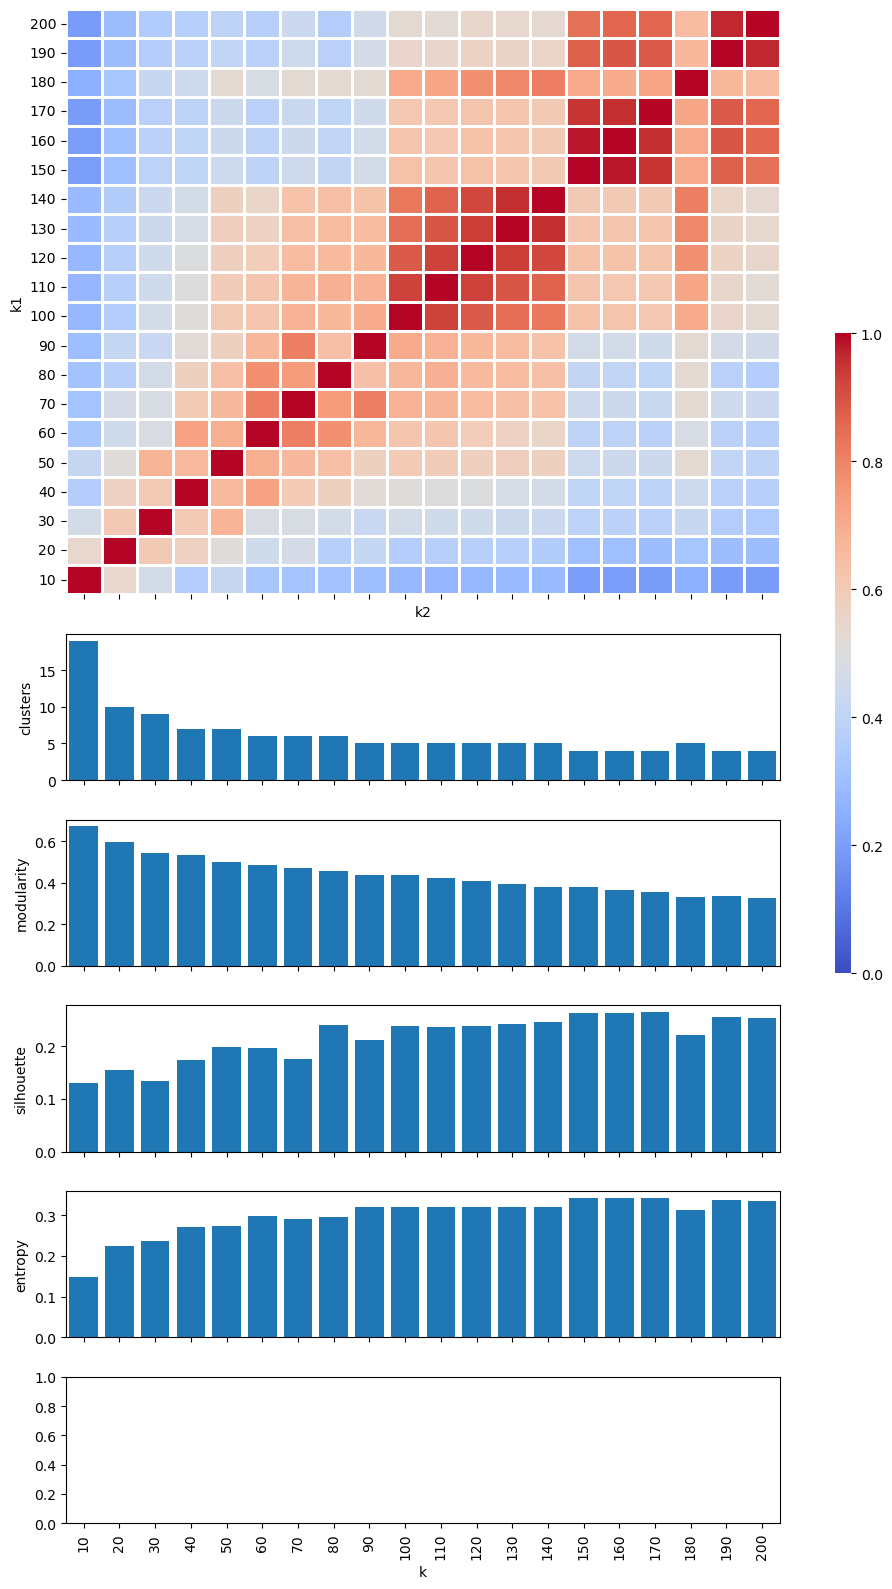

In [130]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plotting(characteristics):

    n = len(characteristics)
    Rand_indices = pd.DataFrame(np.zeros((n,n)), index = ks, columns = ks)

    Rand_indices.index.name = 'k1'
    Rand_indices.columns.name = 'k2'

    for i in range(n):
        for j in range(n):
            Rand_indices.iloc[i, j] = adjusted_rand_score(
                cluster_characteristics['communities'][i], 
                cluster_characteristics['communities'][j]
            )
        
    cluster_characteristics['clusters'] = cluster_characteristics['communities'].apply(lambda x: len(np.unique(x)))
    
    
    fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(8, 16), sharex='col',
                            gridspec_kw={'height_ratios': [16, 4, 4, 4, 4,4]}
                            )
    cbar_ax = fig.add_axes([1.05, .388, .02, .4]) # square=True, 
    sns.heatmap(Rand_indices,
                cmap=('coolwarm'),
                vmin=0,
                vmax=1,
                cbar_ax=cbar_ax,
                xticklabels=False,
                linewidths=1,
                ax=axs[0], 
                #title="adjusted rand index"
               ).invert_yaxis()

    x_ticks = list(Rand_indices.columns)
    x_tick_pos = [i + 0.5 for i in range(len(x_ticks))]

    barplots = ["clusters", "modularity", "silhouette", "entropy"]
    for ax, name in zip(axs[1:], barplots):
        ax.set_ylabel(name)
        ax.bar(x_tick_pos, characteristics[name], align='center')

    axs[-1].set_xticks(x_tick_pos)
    axs[-1].set_xticklabels(x_ticks, rotation=90)
    axs[-1].set_xlabel('k')
    return fig, axs


if run_all:
    plotting(cluster_characteristics)
    plt.tight_layout()
    plt.show()


In [131]:
from phenograph.cluster import cluster as cluster2
communities, graph, modularity = cluster2(data_used, k=35, seed= 20221003, primary_metric="cosine", clustering_algo="leiden")

Finding 35 nearest neighbors using cosine metric and 'brute' algorithm
Neighbors computed in 0.026318073272705078 seconds
Jaccard graph constructed in 0.7711353302001953 seconds
Running Leiden optimization
Leiden completed in 0.1882317066192627 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.5243260860443115 seconds


In [132]:
#data_cluster["label"] = labels
#data_cluster.groupby("label").PATNR.count()
#data_cluster["label"] = labels
data_cluster["label"] = communities + 1

#data_cluster_ = pd.concat([data_cluster,test_ ], axis=1)

print(data_cluster.groupby("label")["Subject ID"].count())
#print(data_cluster.groupby("label_pheno")["Subject ID"].count())
data_cluster = data_cluster

label
1    149
2    102
3     99
4     99
5     92
6     79
7     68
8     62
Name: Subject ID, dtype: int64


In [133]:
len(data_cluster["Subject ID"].unique())

243

In [134]:
import umap
reducer = umap.UMAP(n_neighbors=30, metric='cosine')
embedding = reducer.fit_transform(data_used)

In [135]:
communities, graph, modularity = cluster2(embedding, k=50, seed= 20221003, primary_metric="cosine", clustering_algo="leiden")
communities

Finding 50 nearest neighbors using cosine metric and 'brute' algorithm
Neighbors computed in 0.0363922119140625 seconds
Jaccard graph constructed in 0.7901558876037598 seconds
Running Leiden optimization
Leiden completed in 0.09863615036010742 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.4429035186767578 seconds


array([3, 0, 3, 4, 2, 7, 3, 6, 6, 1, 6, 4, 4, 1, 1, 1, 1, 7, 5, 5, 3, 1,
       6, 0, 2, 3, 2, 6, 1, 7, 1, 1, 5, 7, 1, 5, 7, 6, 2, 1, 3, 3, 3, 1,
       0, 2, 5, 1, 1, 1, 5, 7, 4, 4, 4, 0, 0, 0, 1, 3, 2, 2, 1, 2, 3, 4,
       3, 1, 1, 2, 2, 2, 1, 3, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 6, 3, 3, 4,
       4, 1, 0, 1, 0, 6, 4, 3, 6, 3, 7, 7, 2, 0, 0, 7, 2, 1, 5, 1, 7, 0,
       1, 4, 4, 1, 6, 6, 6, 2, 4, 4, 7, 2, 1, 2, 2, 1, 3, 0, 0, 2, 2, 2,
       3, 0, 2, 4, 3, 4, 1, 3, 7, 0, 4, 3, 0, 0, 2, 4, 0, 3, 7, 4, 4, 0,
       1, 0, 5, 0, 6, 7, 7, 7, 5, 7, 0, 3, 3, 4, 4, 6, 0, 5, 3, 0, 0, 0,
       1, 2, 0, 1, 4, 4, 2, 2, 2, 3, 4, 3, 6, 2, 6, 1, 7, 3, 1, 5, 6, 4,
       3, 1, 3, 7, 6, 0, 5, 5, 0, 7, 0, 1, 5, 0, 0, 3, 5, 3, 4, 3, 0, 1,
       1, 6, 6, 2, 6, 1, 3, 1, 4, 7, 4, 4, 3, 1, 6, 4, 2, 2, 0, 5, 3, 0,
       0, 5, 3, 1, 2, 3, 2, 2, 3, 0, 1, 4, 0, 3, 5, 5, 5, 6, 0, 3, 0, 6,
       4, 6, 3, 3, 3, 7, 5, 0, 7, 5, 5, 0, 1, 6, 6, 5, 1, 6, 7, 1, 1, 2,
       4, 2, 5, 6, 0, 5, 2, 6, 0, 0, 7, 7, 6, 3, 2,

In [136]:
communities

array([3, 0, 3, 4, 2, 7, 3, 6, 6, 1, 6, 4, 4, 1, 1, 1, 1, 7, 5, 5, 3, 1,
       6, 0, 2, 3, 2, 6, 1, 7, 1, 1, 5, 7, 1, 5, 7, 6, 2, 1, 3, 3, 3, 1,
       0, 2, 5, 1, 1, 1, 5, 7, 4, 4, 4, 0, 0, 0, 1, 3, 2, 2, 1, 2, 3, 4,
       3, 1, 1, 2, 2, 2, 1, 3, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 6, 3, 3, 4,
       4, 1, 0, 1, 0, 6, 4, 3, 6, 3, 7, 7, 2, 0, 0, 7, 2, 1, 5, 1, 7, 0,
       1, 4, 4, 1, 6, 6, 6, 2, 4, 4, 7, 2, 1, 2, 2, 1, 3, 0, 0, 2, 2, 2,
       3, 0, 2, 4, 3, 4, 1, 3, 7, 0, 4, 3, 0, 0, 2, 4, 0, 3, 7, 4, 4, 0,
       1, 0, 5, 0, 6, 7, 7, 7, 5, 7, 0, 3, 3, 4, 4, 6, 0, 5, 3, 0, 0, 0,
       1, 2, 0, 1, 4, 4, 2, 2, 2, 3, 4, 3, 6, 2, 6, 1, 7, 3, 1, 5, 6, 4,
       3, 1, 3, 7, 6, 0, 5, 5, 0, 7, 0, 1, 5, 0, 0, 3, 5, 3, 4, 3, 0, 1,
       1, 6, 6, 2, 6, 1, 3, 1, 4, 7, 4, 4, 3, 1, 6, 4, 2, 2, 0, 5, 3, 0,
       0, 5, 3, 1, 2, 3, 2, 2, 3, 0, 1, 4, 0, 3, 5, 5, 5, 6, 0, 3, 0, 6,
       4, 6, 3, 3, 3, 7, 5, 0, 7, 5, 5, 0, 1, 6, 6, 5, 1, 6, 7, 1, 1, 2,
       4, 2, 5, 6, 0, 5, 2, 6, 0, 0, 7, 7, 6, 3, 2,

In [137]:
import umap
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=3, metric='cosine', title='', target= "label"):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    tsne_ng = pd.DataFrame(u, columns=["one","two"]+[f"{x}"for x in range(3,n_components+1)])
    tsne_ng["labels"] = target
    if n_components == 1:
        ax.scatter(u[:,0], range(len(u)), c=tsne_ng.labels)

    tsne_ng.plot.scatter("one","two", c = 'labels', cmap="tab10")
    plt.title(title, fontsize=18)

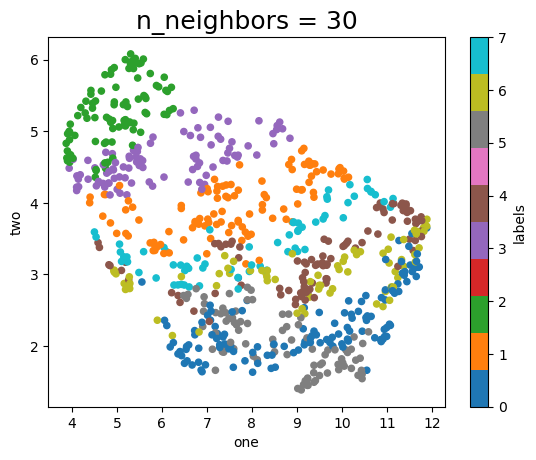

In [138]:
draw_umap(data_used, n_neighbors=30, title='n_neighbors = {}'.format(30), metric="cosine", target=communities)

for n in (2, 5, 10, 20, 30,50, 100, 200):
    draw_umap(data_used, n_neighbors=n, title='n_neighbors = {}'.format(n), metric="minkowski", target=data_cluster["label"])

<Axes: xlabel='one', ylabel='two'>

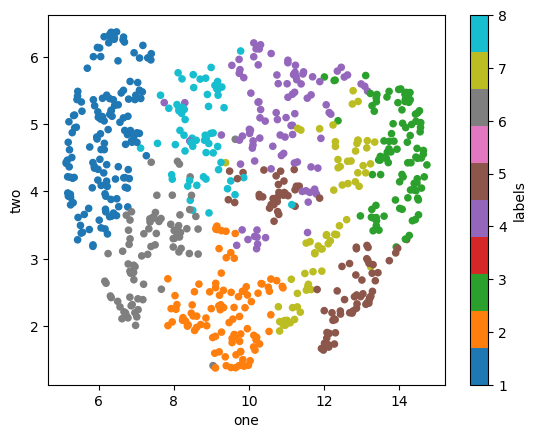

In [139]:
#X_embedded = TSNE(n_components=2, learning_rate='auto',n_jobs = -1,
#                  init='random', perplexity=100).fit_transform(data_used)
tsne_ng = pd.DataFrame(embedding, columns=["one","two"])
tsne_ng["labels"] = data_cluster["label"]
tsne_ng["days"] = data_cluster.days
tsne_ng.plot.scatter("one","two", c = 'labels', cmap="tab10")
#tsne_df.plot.scatter("one","three", c = 'labels', cmap="Set1")
#tsne_df.plot.scatter("two","three", c = 'labels', cmap="Set1")




<Axes: xlabel='one', ylabel='two'>

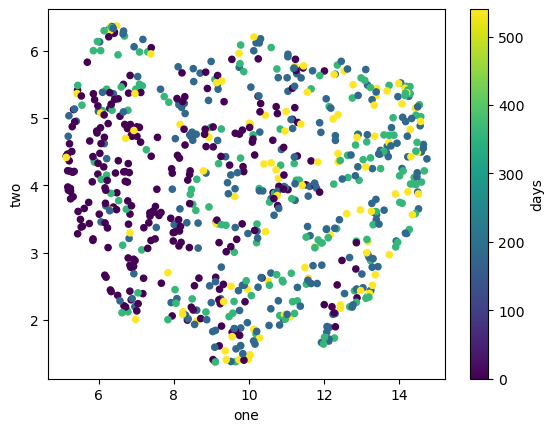

In [140]:

tsne_ng.plot.scatter("one","two", c = 'days', cmap="viridis")

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Creating dataset

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(tsne_df.one, tsne_df.two, tsne_df.three, c= cmap(tsne_df.labels-1), label=tsne_df.labels  )
plt.title("simple 3D scatter plot")
#plt.legend(tsne_df.labels.value_counts().index,cmap(tsne_df.labels.value_counts().index))
# show plot
plt.show()


In [141]:
pca_data = data_used

components = 3
pca = PCA(n_components=components).fit(pca_data)
pca_trans = pca.transform(pca_data)
principalDf = pd.DataFrame(data = pca_trans
             , columns = [f'principal component {x}' for x in range(1,components+1)])
principalDf["label"] = communities
principalDf["days"] = data_use.days
pca.explained_variance_ratio_

array([0.49885782, 0.19599267, 0.11688946])

In [142]:
pca.mean_

array([0.20861905, 0.14128   , 0.15952   , 0.26441975, 0.62455752,
       0.20703099])

,principal component 1,principal component 2,principal component 3,label,days
0,0.823904,0.084194,-0.147406,3,0
1,-0.200771,0.115980,-0.067805,0,90
2,0.304258,-0.234514,0.133531,3,180
3,-0.123328,-0.055484,0.059888,4,0
4,0.110907,-0.158523,-0.081926,2,90
...,...,...,...,...,...
745,-0.221949,0.020336,0.007169,0,360
746,0.362740,-0.046792,0.018796,3,450
747,0.332718,-0.217205,-0.081701,2,540
748,0.514464,-0.228990,-0.232496,2,0


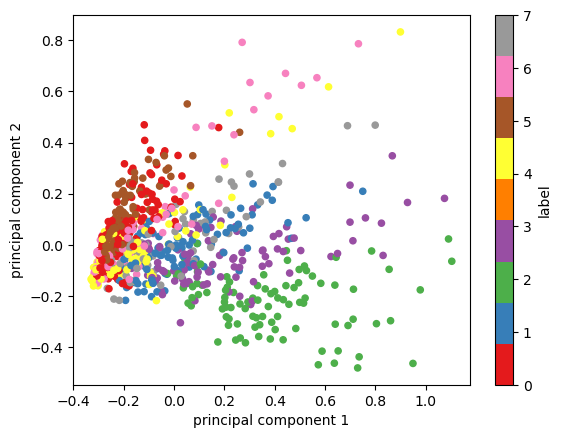

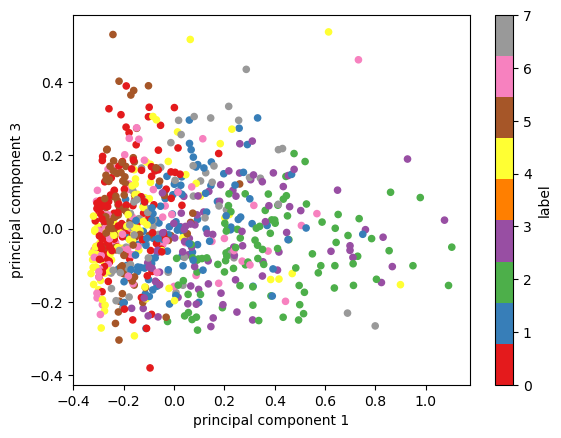

In [143]:
principalDf.plot.scatter(x="principal component 1", y="principal component 2", c="label", cmap="Set1")
principalDf.plot.scatter(x="principal component 1", y="principal component 3", c="label", cmap="Set1")
#principalDf.plot.scatter(x="principal component 2", y="principal component 3", c="label", cmap="Set1")
#principalDf.plot.scatter(x="principal component 1", y="principal component 4", c="label", cmap="Set1")
principalDf

In [144]:
data_cluster



,Subject ID,months,Study,Age,Race,Sex,Weight,Date of Assessment,Date of symptom onset,Final Score,...,seropos,Hemoglobulin,hemoglobin,das_28_c,visit_count,predni,m_dmards,dmard_usage,remision,label
0,0073B9C958B3CA3EED99BB233FD6AA03D42883B16AED8D...,0,TACERA,79,White- British,1,50.80,6/25/2015,2/1/2015,9.0,...,True,6.95072,7.45072,7.278203,2,1,False,True,0,1
1,0073B9C958B3CA3EED99BB233FD6AA03D42883B16AED8D...,6,TACERA,79,White- British,1,50.80,6/25/2015,2/1/2015,9.0,...,True,6.88866,7.38866,2.328413,2,0,True,True,1,2
2,0110A6D8FE1F42B8F690C418F4A76379A3D95E0B68E625...,0,TACERA,42,White- British,1,73.40,8/9/2013,3/2/2013,0.0,...,True,8.68840,9.18840,4.963557,4,1,True,True,0,1
3,0110A6D8FE1F42B8F690C418F4A76379A3D95E0B68E625...,6,TACERA,42,White- British,1,73.40,8/9/2013,3/2/2013,0.0,...,True,8.00574,8.50574,2.983482,4,0,True,True,0,5
4,0110A6D8FE1F42B8F690C418F4A76379A3D95E0B68E625...,12,TACERA,42,White- British,1,73.40,8/9/2013,3/2/2013,0.0,...,True,7.94368,8.44368,4.521627,4,0,True,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,FF316CBA26DD9BC1E0575F0930ECE7A0F15F9D2B3FED6C...,6,TACERA,69,White- British,0,94.45,2/2/2015,10/5/2014,19.0,...,True,8.87458,8.37458,2.159716,2,1,True,True,1,7
746,FF9C17EC739F92CED4EDC266471525E0F50F8A81C9129B...,0,TACERA,52,Asian or Asian British - Any other Asian backg...,1,80.00,2/5/2014,7/8/2013,1.0,...,True,7.88162,8.38162,5.842586,4,0,True,True,0,1
747,FF9C17EC739F92CED4EDC266471525E0F50F8A81C9129B...,6,TACERA,52,Asian or Asian British - Any other Asian backg...,1,80.00,2/5/2014,7/8/2013,1.0,...,True,8.12986,8.62986,5.505155,4,1,True,True,0,1
748,FF9C17EC739F92CED4EDC266471525E0F50F8A81C9129B...,12,TACERA,52,Asian or Asian British - Any other Asian backg...,1,80.00,2/5/2014,7/8/2013,1.0,...,True,7.88162,8.38162,6.397339,4,0,True,True,0,1


In [145]:
data_used = pd.DataFrame(data_used, columns = [f"{x}_n" for x in features])
data_used

,TJC_28_n,SJC_28_n,ESR_n,leukocytes_n,hemoglobin_n,thrombocytes_n
0,0.714286,0.76,0.472,0.207176,0.469377,0.277778
1,0.000000,0.08,0.072,0.253472,0.458973,0.235828
2,0.535714,0.28,0.064,0.403935,0.760699,0.196145
3,0.178571,0.00,0.048,0.346065,0.646251,0.190476
4,0.464286,0.04,0.088,0.230324,0.635847,0.189342
...,...,...,...,...,...,...
745,0.000000,0.08,0.056,0.212963,0.624262,0.268707
746,0.464286,0.40,0.224,0.311343,0.625443,0.226757
747,0.678571,0.12,0.136,0.241898,0.667060,0.210884
748,0.821429,0.24,0.240,0.103009,0.625443,0.168934


In [146]:
data_heatmap = data_cluster.copy()
#data_heatmap["SJC"] = scaler_minmax.fit_transform( data_use.SJC_28.values.reshape(-1,1))
#data_heatmap["TJC"] = scaler_minmax.fit_transform(data_use.TJC_28.values.reshape(-1,1))
features_n = data_used.columns
data_heatmap[data_used.columns] = data_used
data_heatmap["das28_n"] = scaler.fit_transform(data_cluster["DAS28"].values.reshape(-1,1))
data_heatmap["das28"] = data_cluster["DAS28"]
data_heatmap["aCCP positive"] = data_cluster['acpa'].astype(bool)
data_heatmap["RF positive"] = data_cluster['RF'] 
data_heatmap["label"] = data_cluster["label"].astype(int)

data_heatmap["days"] = data_cluster.days

data_heatmap["PATNR"] = data_cluster["Subject ID"]
data_heatmap["DATUM"] = data_cluster["months"]
data_heatmap["Age"] = data_cluster.Age
data_heatmap["sex"] = data_cluster.Sex.astype(int)

data_heatmap["predni"] = data_cluster[predni].max(axis=1)
#data_heatmap["das28"] = data_cluster["DAS28"]
#data_heatmap["aCCP positive"] = data_cluster['ACPA positive']
#data_heatmap["RF positive"] = data_cluster['Rheum Factor positive'] 
#data_heatmap["label"] = data_cluster["label"]
#data_heatmap["label_pheno"] = data_cluster["label_pheno"]
#data_heatmap["days"] = data_cluster.days
#data_heatmap["PATNR"] = data_cluster["Subject ID"]
#ata_heatmap["DATUM"] = data_cluster["months"]
#data_heatmap["Age"] = data_cluster.Age
#data_heatmap["sex"] = data_cluster.Sex

data_heatmap[dmards] = data_cluster[dmards]

volgorde= pd.Index(list(range(len(data_heatmap.label.unique()),0,-1))).astype(int)



In [147]:
data_heatmap["label"].unique()

array([1, 2, 5, 3, 4, 7, 6, 8])

In [148]:
data_heatmap["L2"] = (data_heatmap.label == 2)*1
data_heatmap["L1"] = (data_heatmap.label == 1)*1
data_heatmap.groupby("PATNR").L2.max().describe()
#data_heatmap.groupby("PATNR").L1.max().describe()

count    243.000000
mean       0.275720
std        0.447799
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: L2, dtype: float64

for i in features +["TJC_44","SJC_44",]:
    print(f"{i}_o")
    data_heatmap.boxplot(column=f"{i}_o", by="label", grid=False)
    print(data_heatmap.groupby("label")[[f"{i}_o"]].describe())

<Axes: xlabel='label'>

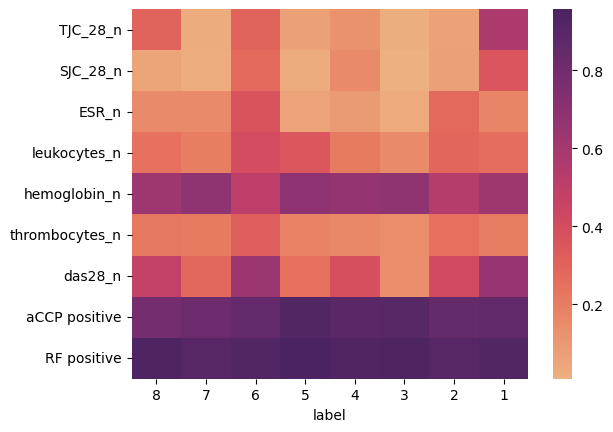

In [149]:
add_features = ["das28_n","aCCP positive","RF positive"]
sns.heatmap(data_heatmap.groupby("label")[
        [x for x in features_n ]+add_features].mean().transpose()[volgorde],
                cmap="flare",)

In [150]:
volgorde= pd.Index(list(range(len(data_heatmap.label.unique()),0,-1))).astype(int)
print(volgorde)
data_heatmap.label.unique()
volgorde_base = data_heatmap.groupby("label").days.mean().sort_values().index
volgorde = dict(zip(volgorde_base,volgorde))
data_heatmap.label = data_heatmap.label.replace(volgorde)

volgorde = pd.Index(sorted(volgorde.values(), reverse=True))
data_heatmap.label
volgorde

Index([8, 7, 6, 5, 4, 3, 2, 1], dtype='int64')


Index([8, 7, 6, 5, 4, 3, 2, 1], dtype='int64')

<Axes: xlabel='label'>

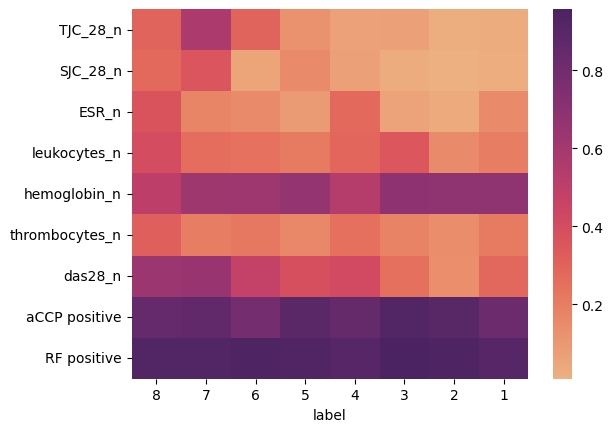

In [151]:
sns.heatmap(data_heatmap.groupby("label")[
        [x for x in features_n ]+add_features].mean().transpose()[volgorde],
                cmap="flare",)

In [152]:
#volgorde = [9, 3, 5, 2, 1, 7, 6, 4]
#volgorde = dict(zip(volgorde_base,volgorde))
#print(dict(zip(volgorde_base,volgorde)))
#data_heatmap.label = data_heatmap.label.replace(volgorde)
volgorde_dic = {8:6,7:7,5:4,6:9,4:5,3:3,2:1,1:2}
data_heatmap.label = data_heatmap.label.replace(volgorde_dic)
data_heatmap.to_csv(data_dir +"TACERA_clean.csv")
data_dir +"TACERA_clean.csv"

volgorde = pd.Index(sorted(volgorde_dic.values(), reverse=True))
print(volgorde)
volgorde_text = [f"T{x}" for x in volgorde]



Index([9, 7, 6, 5, 4, 3, 2, 1], dtype='int64')


In [153]:
#heatmap_plot(data_heatmap)

In [154]:

data_heatmap["to_clust"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label.shift(-1,axis=0, fill_value=-1)
data_heatmap["to_clust"]=data_heatmap.to_clust.astype(int)
data_heatmap["label_text"]= data_heatmap.label.astype(str)
data_heatmap["to_clust_text"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label_text.shift(-1,axis=0, fill_value=-1)
data_heatmap["label"]= data_heatmap.label.astype(int)

volgorde_tijd = data_heatmap.groupby("label").days.mean().sort_values().index
volgorde_tijd

/tmp/ipykernel_750615/2145126360.py:1: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  data_heatmap["to_clust"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label.shift(-1,axis=0, fill_value=-1)
/tmp/ipykernel_750615/2145126360.py:4: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  data_heatmap["to_clust_text"] = data_heatmap.sort_values("days").groupby(["PATNR"]).label_text.shift(-1,axis=0, fill_value=-1)


Index([6, 7, 9, 4, 5, 3, 1, 2], dtype='int64', name='label')

In [155]:
add_features = ["das28_n","aCCP positive","RF positive"]
#data_heatmap["umap_labels"] = communities
#pd.crosstab(data_heatmap["umap_labels"], data_heatmap["label"])   

In [156]:
data_heatmap.groupby("label")[
        [x for x in features_n ]+add_features].mean().transpose()

label,1,2,3,4,5,6,7,9
TJC_28_n,0.018038,0.026786,0.068711,0.129149,0.067927,0.297016,0.570230,0.296659
SJC_28_n,0.008889,0.022941,0.026087,0.153939,0.071373,0.275949,0.357852,0.056129
ESR_n,0.032727,0.149765,0.059217,0.086788,0.276706,0.364557,0.172725,0.151871
leukocytes_n,0.153742,0.199057,0.356192,0.211244,0.287616,0.403488,0.264099,0.246976
hemoglobin_n,0.683587,0.683801,0.687407,0.664474,0.531943,0.504826,0.619766,0.624768
thrombocytes_n,0.142674,0.210818,0.179422,0.163391,0.250767,0.316944,0.197994,0.226008
das28_n,0.140599,0.284648,0.250660,0.389165,0.411636,0.634783,0.647076,0.475173
aCCP positive,0.898990,0.823529,0.923913,0.888889,0.852941,0.848101,0.865772,0.790323
RF positive,0.939394,0.911765,0.956522,0.929293,0.911765,0.924051,0.926174,0.935484


In [157]:
data_heatmap.columns

Index(['Subject ID', 'months', 'Study', 'Age', 'Race', 'Sex', 'Weight',
       'Date of Assessment', 'Date of symptom onset', 'Final Score',
       'Unnamed: 10', 'acpa', 'RF', 'ACPA positive SCR',
       'Rheum Factor positive SCR', 'Basophils', 'CRP Value (mg/L)',
       'DAS-28 CRP', 'DAS28', 'ESR', 'Eosinophils', 'GL', 'HB', 'Lymphocytes',
       'Monocytes', 'Neutrophils', 'thrombocytes', 'SJC_28', 'TJC_28',
       'leukocytes', 'Adalimumab', 'Certolizumab', 'Dexamethasone',
       'Etanercept', 'Folic Acid', 'Golimumab', 'Hydroxychloroquine',
       'Leflunomide', 'Methotrexate', 'Methylprednisolone',
       'Methylprednisolone Acetate', 'Prednisolone', 'Sulfasalazine',
       'Tocilizumab', 'Triamcinolone (Kenalog)', 'days', 'seropos',
       'Hemoglobulin', 'hemoglobin', 'das_28_c', 'visit_count', 'predni',
       'm_dmards', 'dmard_usage', 'remision', 'label', 'TJC_28_n', 'SJC_28_n',
       'ESR_n', 'leukocytes_n', 'hemoglobin_n', 'thrombocytes_n', 'das28_n',
       'das28', '

In [158]:
volgorde


Index([9, 7, 6, 5, 4, 3, 2, 1], dtype='int64')

<Axes: xlabel='label'>

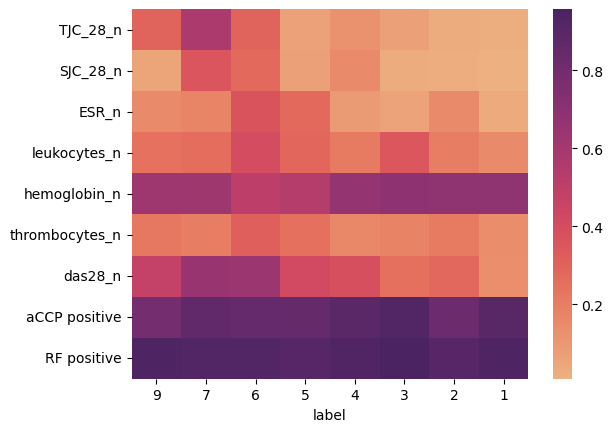

In [159]:
sns.heatmap(data_heatmap.groupby("label")[
        [x for x in features_n ]+add_features].mean().transpose()[volgorde],
                cmap="flare",)

In [160]:
volgorde_tijd = list(data_heatmap.groupby("label").days.mean().sort_values().index)
volgorde_tijd[-5:] = [5,4,3,2,1]
volgorde_tijd[3:5] = [5,4]
pd.Index(volgorde_tijd) 


Index([6, 7, 9, 5, 4, 3, 2, 1], dtype='int64')

/tmp/ipykernel_750615/4137013766.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  size = df.groupby("label").apply(lambda x:len(x))
/tmp/ipykernel_750615/4137013766.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uni_pat = df.groupby("label").apply(lambda x:len(x.PATNR.unique()))


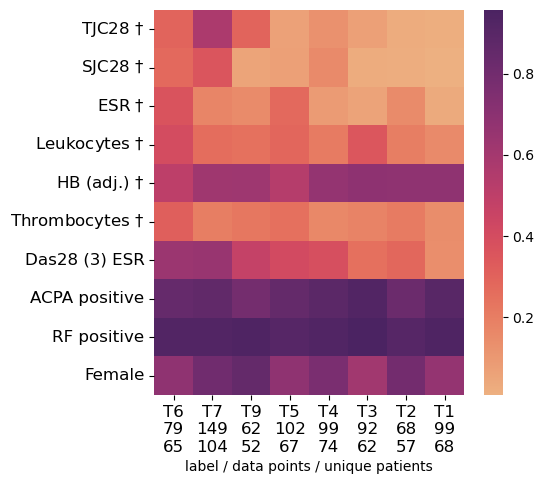

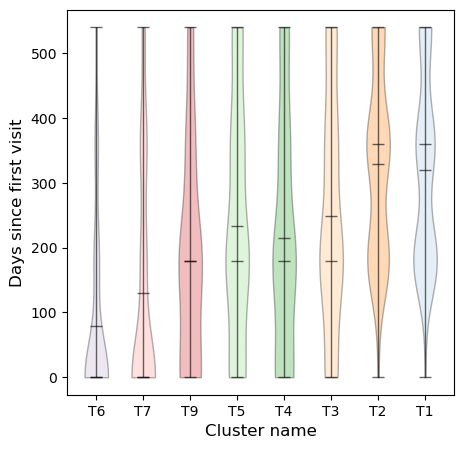

In [161]:
#plt.rcParams.update({'font.size': 10})
cmap = plt.get_cmap("tab20")
def heatmap_plot(df:pd.DataFrame, target="label"):
    cmap = plt.get_cmap("tab20")
    features_figure = ['TJC28',  'SJC28',   'ESR',  'Leukocytes',  'HB (adj.)',  'Thrombocytes']
    add_features = ["das28_n","aCCP positive","RF positive", "sex"]
    add_features_fig = ["Das28 (3) ESR","ACPA positive","RF positive", "Female"]
    y_labels = [f"{x} $\dagger$" for x in features_figure if x  ] + add_features_fig
    volgorde_tijd = list(data_heatmap.groupby("label").days.mean().sort_values().index)
    volgorde_tijd[-5:] = [5,4,3,2,1]
    volgorde_tijd = pd.Index(volgorde_tijd) 

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    sns.heatmap(df.groupby(target)[
        [x for x in features_n ]+add_features].mean().transpose()[volgorde_tijd],
                cmap="flare", ax=axs,
                yticklabels = y_labels,)
    
    size = df.groupby("label").apply(lambda x:len(x))
    uni_pat = df.groupby("label").apply(lambda x:len(x.PATNR.unique()))
    axs.set_xticks(np.array(range(len(size)))+ 0.5)
    axs.set_xticklabels([f"T{i}\n{size.loc[int(i)]}\n{uni_pat.loc[int(i)]}"for i in volgorde_tijd], fontsize=12)
    axs.set_yticklabels(y_labels, fontsize=12)
    axs.set_xlabel("label / data points / unique patients")
    plt.savefig(results_dir+"heatmap_tacera", dpi=900, transparent=True, bbox_inches='tight')
    fig.show()
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    violin_parts  = axs.violinplot([df[df[target] == label].days for label in volgorde_tijd],
                      showmeans=True, showextrema=True, showmedians=True, )
    for partname in ('cbars','cmins','cmaxes','cmedians', "cmeans"):
            vp = violin_parts[partname]
            vp.set_edgecolor("black")
            vp.set_linewidth(1)
            vp.set_alpha(0.6) 
    for nr, pc in enumerate(violin_parts["bodies"]):
        pc.set_color(cmap(int(volgorde[nr])))
        pc.set_edgecolor("black")
    axs.set_xticks(range(1,len(volgorde)+1))
    axs.set_xticklabels([f"T{i}"for i in volgorde_tijd])
    axs.set_ylabel("Days since first visit", fontsize=12)
    axs.set_xlabel("Cluster name", fontsize=12)
    plt.savefig(results_dir+"violin_tacera", dpi=900, transparent=True, bbox_inches='tight')
    fig.show()
    #plt.subplots_adjust( left=0.25), dpi=900, transparent=True, bbox_inches='tight')

heatmap_plot(data_heatmap)
#


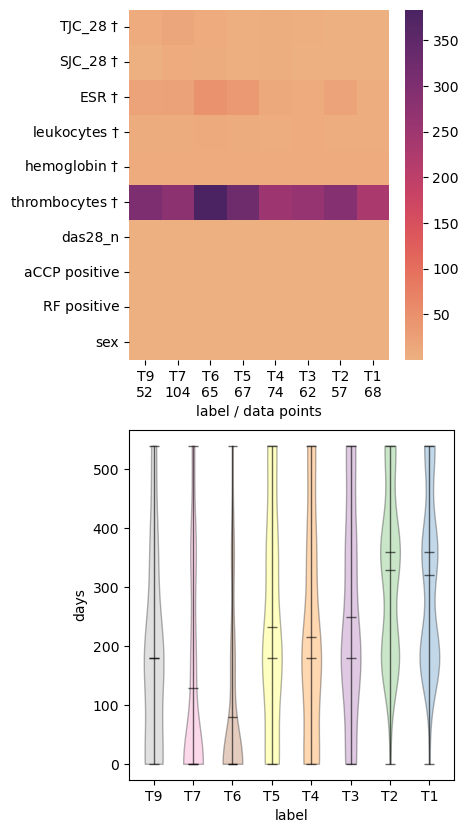

In [162]:
cmap = plt.get_cmap("Set1")
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
y_labels = [f"{x} $\dagger$" for x in features] + ["das28_n","aCCP positive","RF positive", "sex"]
sns.heatmap(data_heatmap.groupby("label")[list(features)+["das28_n","aCCP positive","RF positive", "sex"]].mean().transpose()[volgorde],
            cmap="flare", ax=axs[0], yticklabels = y_labels)
violin_parts  = axs[1].violinplot([data_heatmap[data_heatmap.label == label].days for label in volgorde],
                  showmeans=True, showextrema=True, showmedians=True, )
for partname in ('cbars','cmins','cmaxes','cmedians', "cmeans"):
        vp = violin_parts[partname]
        vp.set_edgecolor("black")
        vp.set_linewidth(1)
        vp.set_alpha(0.6) 
for nr, pc in enumerate(violin_parts["bodies"]):
    pc.set_color(cmap(int(volgorde[nr])))
    pc.set_edgecolor("black")

    
size = data_heatmap.groupby("label").PATNR.unique().apply(lambda x:len(x))
axs[0].set_xticklabels([f"T{i}\n{size.loc[i]}"for i in volgorde])
axs[1].set_ylabel("days")
axs[0].set_xlabel("label / data points")
axs[1].set_xlabel("label")
axs[1].set_xticks(range(1,len(volgorde)+1))
axs[1].set_xticklabels(volgorde_text)
axs[1].set_ylabel("days")
axs[1].set_xlabel("label")
plt.subplots_adjust( left=0.25)
plt.savefig(results_dir+"heatmap_TACERA", dpi=900, transparent=True, bbox_inches='tight')
#plt.savefig(f'{title}.png', dpi=900, transparent=True, bbox_inches='tight')


In [163]:
for i in features:
    print(f"{i}_o")
    #data_heatmap.boxplot(column=f"{i}_o", by="label", grid=False)

TJC_28_o
SJC_28_o
ESR_o
leukocytes_o
hemoglobin_o
thrombocytes_o


In [164]:
data_heatmap.PATNR.unique().__len__()

243

In [165]:
data_heatmap.loc[data_heatmap.query("sex == 'Female'").index,"sex"] = 1
data_heatmap.loc[data_heatmap.query("sex == 'Male'").index ,"sex"] = 0
data_heatmap.sex = data_heatmap.sex.astype(int)

In [166]:
data_heatmap.groupby("label").Age.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1,99.0,46.959596,14.648201,20.0,34.00,45.0,56.0,75.0
2,68.0,55.647059,14.432307,26.0,45.50,55.5,65.5,84.0
3,92.0,50.336957,15.463731,20.0,37.75,51.5,63.5,79.0
4,99.0,53.888889,15.503054,21.0,42.50,56.0,67.0,84.0
5,102.0,59.833333,12.451159,29.0,50.00,61.0,69.0,84.0
6,79.0,56.189873,14.068583,20.0,48.50,57.0,67.0,84.0
7,149.0,50.718121,15.462719,20.0,39.00,52.0,62.0,84.0
9,62.0,48.854839,13.840836,20.0,42.00,49.0,57.0,84.0


In [167]:
general_dataset = Propensity(data_heatmap,                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
general_dataset.calc_transition_matrix()
pd_from_total = general_dataset.traject_props

male_dataset = Propensity(data_heatmap.query('sex==0'),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
male_dataset.calc_transition_matrix()
female_dataset = Propensity(data_heatmap.query('sex==1'),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
female_dataset.calc_transition_matrix()


/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


Text(0.5, 1.0, 'Combined')

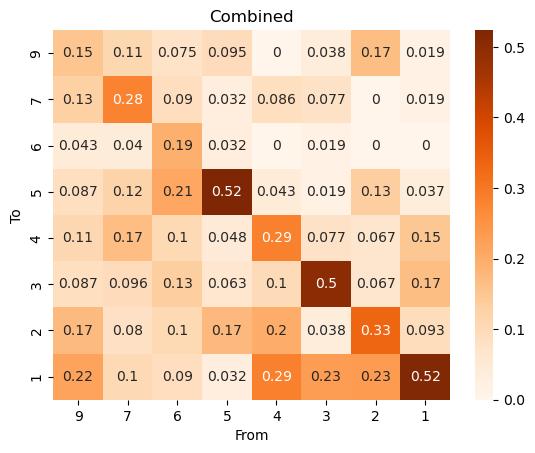

In [168]:
ax = sns.heatmap(general_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_ylabel("To")
ax.set_xlabel("From")
ax.set_title("Combined")

Text(0.5, 1.0, 'Male')

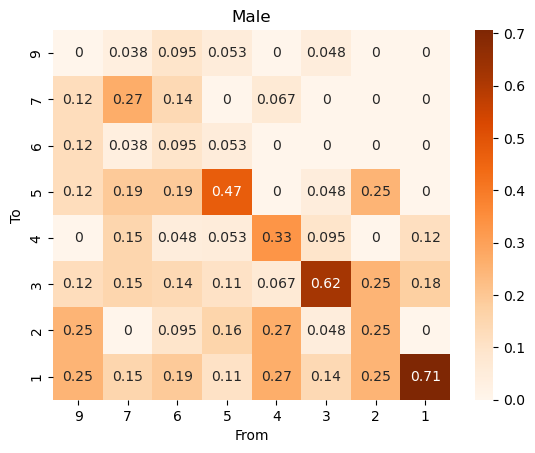

In [169]:
ax = sns.heatmap(male_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_ylabel("To")
ax.set_xlabel("From")
ax.set_title("Male")

Text(0.5, 1.0, 'Female')

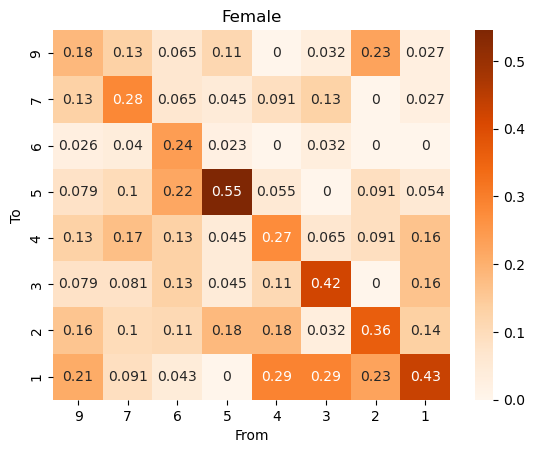

In [170]:
ax = sns.heatmap(female_dataset.traject_props, cmap='Oranges', annot=True)
ax.set_ylabel("To")
ax.set_xlabel("From")
ax.set_title("Female")

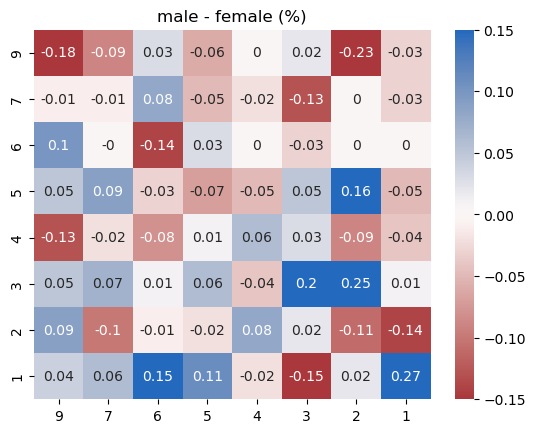

In [171]:
ax = sns.heatmap((male_dataset.traject_props-female_dataset.traject_props).round(2), cmap='vlag_r', annot=True, vmin=-0.15, vmax=0.15)
ax.set_title("male - female (%)")
plt.show()

In [172]:
data_heatmap.loc[data_heatmap.query(" Age < 35").index,"age_cate"] = "young"
data_heatmap.loc[data_heatmap.query("50 > Age > 35").index,"age_cate"] = "middle"
data_heatmap.loc[data_heatmap.query(" Age > 50").index,"age_cate"] = "old"
data_heatmap["seasons"] = pd.to_datetime(data_heatmap.DATUM).dt.month

In [173]:
data_heatmap.groupby(["PATNR","label"]).head(1).reset_index(drop=True).groupby(["label"])[["aCCP positive","RF positive"]].mean().loc[volgorde]

,aCCP positive,RF positive
9,0.807692,0.942308
7,0.817308,0.932692
6,0.830769,0.938462
5,0.835821,0.895522
4,0.878378,0.932432
3,0.903226,0.951613
2,0.789474,0.912281
1,0.897059,0.926471


In [174]:
data_heatmap.groupby(["PATNR","label"]).head(1).reset_index(drop=True).groupby(["label"])[["aCCP positive","RF positive"]].count().loc[volgorde]

,aCCP positive,RF positive
9,52,52
7,104,104
6,65,65
5,67,67
4,74,74
3,62,62
2,57,57
1,68,68


In [175]:
acpa_neg_dataset = Propensity(data_heatmap.query('`aCCP positive` == 0'),                    
                    time_column= "days",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
acpa_neg_dataset.calc_transition_matrix()
acpa_pos_dataset = Propensity(data_heatmap.query("`aCCP positive` == 1"),                    
                    time_column= "DATUM",
                    label_column = "label",
                    patient_indetifier= "PATNR",
                    med_array=dmards,)
acpa_pos_dataset.calc_transition_matrix()

acpa_neg_dataset.calc_transition_matrix()
data_heatmap.query('`aCCP positive` == True').groupby("PATNR")

/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)
/exports/reum/nsteinz/Project_trajectories/trajectories/src/2_clustering/../utils/propensity.py:33: FutureWarning: The 'axis' keyword in SeriesGroupBy.shift is deprecated and will be removed in a future version. Call without passing 'axis' instead.
  .shift(-1, axis=0, fill_value=-1)


In [176]:
#data_heatmap.to_csv(data_dir+"tacera_cluster_data.csv", index=False)

In [177]:
#pd.read_csv('/exports/reum/nsteinz/data/TACERA_data_2024-01-05.csv')